# Frequency analysis and sentiment with NLTK

find_word_freq_readfiles.ipynb

### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence were a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.

### 2 ###
•	Sentiment analysis using NLTK.



##############################################################


### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence were a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.


In [ ]:
import nltk
nltk.download("stopwords")

In [15]:
import pandas as pd


#file_df_analysis = '/project/elife/data/analysis/df_5000_prep.csv'
#file_df_analysis_hist = '/project/elife/data/analysis/df_5000_prep_hist.csv'
file_df_analysis = '/project/elife/data/analysis/df_science1179052_retracted.csv'
file_df_analysis_hist = '/project/elife/data/analysis/df_science1179052_retracted_hist_v2.csv'




df = pd.read_csv(file_df_analysis, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI', 'cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])
# Original:
# df['cited_DOI', 'citing_DOI', 'reference_id', 'introduction_found', 
    #   'cited_in_introduction', 'maintext_found', 'cited_in_maintext', 
    #   'discussion_found', 'cited_in_discussion', 'conclusions_found', 
    #   'cited_in_conclusions', 'sentence_citing_intro', 
    #   'sentence_citing_maintext', 'sentence_citing_discussion', 
    #   'sentence_citing_conclusions']

    
df_hist = pd.read_csv(file_df_analysis_hist, sep='\t', header = None, encoding='utf-8', names =  ['DOI_cited', 'cited_in_conlusions', 'cited_in_discussion', 'cited_in_introduction','cited_in_maintext', 'papers_all_sections_found', 'total_papers_citing'])                                                              
# df_hist =  ['DOI_cited', 'cited_in_conlusions', 'cited_in_discussion', 
    #   'cited_in_introduction','cited_in_maintext', 'papers_all_sections_found',
    #   'total_papers_citing'])    
        


#df_analysis.head(4)    
df[df['cited_DOI'] == df_hist.iloc[0].DOI_cited]

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_id,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,False,10.1186/1477-7525-12-64,True,True,True,True,B50,NaN,NaN,NaN,NaN
1,10.1126/science.1179052,False,False,False,False,DOI not found,False,False,False,True,B2,NaN,NaN,NaN,NaN
2,10.1126/science.1179052,False,False,True,True,10.1371/journal.pone.0027870,False,True,True,True,pone.0027870-Lombardi1,NaN,NaN,"['In 2009, Lombardi<italic>et al.</italic>repo...",['For amplification of XMRV/MLV<italic>gag</it...
3,10.1126/science.1179052,False,False,False,True,10.1186/1741-7007-8-124,False,False,False,True,B1,NaN,NaN,NaN,"['[<xref ref-type=""bibr"" rid=""B1"">1</xref>] re..."
4,10.1126/science.1179052,False,False,True,False,10.1186/1471-2180-11-2,True,True,True,True,B8,NaN,NaN,['The most recent example is xenotropic murine...,NaN
5,10.1126/science.1179052,True,False,False,False,10.1186/1471-2377-11-37,True,True,True,True,B47,['This report of the possible contribution of ...,NaN,NaN,NaN
6,10.1126/science.1179052,False,False,False,False,10.1186/1471-2377-11-62,True,True,True,True,B43,NaN,NaN,NaN,NaN
7,10.1126/science.1179052,False,False,True,False,10.1186/1471-2377-11-82,True,True,True,True,B31,NaN,NaN,['Novel retroviruses may also be involved [<xr...,NaN
8,10.1126/science.1179052,False,True,False,True,10.1186/1471-2377-10-73,True,True,True,True,B25,NaN,"['Recently, a link between the xenotropic muri...",NaN,"['Recently, a link between the xenotropic muri..."
9,10.1126/science.1179052,False,True,False,True,10.1186/1744-9081-6-76,True,True,True,True,B11,NaN,['Evidence of xenotropic murine leukemia virus...,NaN,['Evidence of xenotropic murine leukemia virus...


In [16]:
df_filtered = df['sentence_citing_maintext'].dropna()

df_filtered

2     ['For amplification of XMRV/MLV<italic>gag</it...
3     ['[<xref ref-type="bibr" rid="B1">1</xref>] re...
8     ['Recently, a link between the xenotropic muri...
9     ['Evidence of xenotropic murine leukemia virus...
10    ['These deficiencies in NK activity may increa...
11    ['Both cell associated and cell-free transmiss...
13    ['More recently, Lombardi,<italic>et al</itali...
14    ['reported finding a gammaretrovirus in periph...
15    ['Avenida de Córdoba sn, Madrid 28041, Spain; ...
16    ['Recent findings of XMRV sequences in up to 6...
17    ['RD-114 is expressed by all species of the ge...
18    ['[<xref ref-type="bibr" rid="B8">8</xref>] (T...
19    ['More recently, XMRV has also been found, wit...
20    ['In 2009, a high incidence of XMRV infection ...
22    ['Remarkably, the 22Rv1 sequences displayed av...
23    ['<html><body><p>c&gt;<sec><title>Results and ...
24    ['Plasma samples of CFS patients were simultan...
27    ['In addition, we collected 37 blood sampl

In [18]:
was_intro_found = df['introduction_found'] == True
df_filtered = df[was_intro_found]
print(df_filtered.shape)
df_filtered

(31, 15)


,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_id,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,False,10.1186/1477-7525-12-64,True,True,True,True,B50,NaN,NaN,NaN,NaN
2,10.1126/science.1179052,False,False,True,True,10.1371/journal.pone.0027870,False,True,True,True,pone.0027870-Lombardi1,NaN,NaN,"['In 2009, Lombardi<italic>et al.</italic>repo...",['For amplification of XMRV/MLV<italic>gag</it...
4,10.1126/science.1179052,False,False,True,False,10.1186/1471-2180-11-2,True,True,True,True,B8,NaN,NaN,['The most recent example is xenotropic murine...,NaN
5,10.1126/science.1179052,True,False,False,False,10.1186/1471-2377-11-37,True,True,True,True,B47,['This report of the possible contribution of ...,NaN,NaN,NaN
6,10.1126/science.1179052,False,False,False,False,10.1186/1471-2377-11-62,True,True,True,True,B43,NaN,NaN,NaN,NaN
7,10.1126/science.1179052,False,False,True,False,10.1186/1471-2377-11-82,True,True,True,True,B31,NaN,NaN,['Novel retroviruses may also be involved [<xr...,NaN
8,10.1126/science.1179052,False,True,False,True,10.1186/1471-2377-10-73,True,True,True,True,B25,NaN,"['Recently, a link between the xenotropic muri...",NaN,"['Recently, a link between the xenotropic muri..."
9,10.1126/science.1179052,False,True,False,True,10.1186/1744-9081-6-76,True,True,True,True,B11,NaN,['Evidence of xenotropic murine leukemia virus...,NaN,['Evidence of xenotropic murine leukemia virus...
10,10.1126/science.1179052,False,True,False,True,10.1186/1479-5876-8-1,True,True,True,True,B47,NaN,['These deficiencies in NK activity may increa...,NaN,['These deficiencies in NK activity may increa...
11,10.1126/science.1179052,False,True,True,True,10.1186/1479-5876-7-96,True,True,True,True,B13,NaN,['Both cell associated and cell-free transmiss...,['These observations have led to reports of as...,['Both cell associated and cell-free transmiss...


In [19]:
df_filtered.drop('sentence_citing_intro', axis=1, inplace=False).describe()

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_id,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_maintext
count,31,31,31,31,31,31,31,31,31,31,31,3,13,20
unique,1,2,2,2,2,31,2,2,1,1,20,3,13,20
top,10.1126/science.1179052,False,False,True,True,10.1186/1742-4690-7-101,True,True,True,True,B3,['Additional findings from the Hué study sugge...,['who found that activation of PBMCs from pati...,"['Remarkably, the 22Rv1 sequences displayed av..."
freq,31,28,18,21,20,1,27,24,31,31,4,1,1,1


#### Let's find the most frequente words in an example of a representative sentence for each section (intro, discussion, etc) where the paper is cited.

In [29]:
import re
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "/project/elife/modules")
import words_frec_analysis_get_sentence

file_df = '/project/elife/data/analysis/df_science1179052_retracted.csv'

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])
#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']


print('cited_DOI: ', df.cited_DOI.unique())


print("\n------------- ANALYSIS INTRODUCTION -----------")
sentences_intro = df.sentence_citing_intro.dropna()
if not sentences_intro.empty:
    words_frec_analysis_get_sentence.analysis(sentences_intro)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS MAINTEXT -----------")
sentences_maintext = df.sentence_citing_maintext.dropna()
if not sentences_maintext.empty:
    words_frec_analysis_get_sentence.analysis(sentences_maintext)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS DISCUSSION -----------")
sentences_discussion = df.sentence_citing_discussion.dropna()
if not sentences_discussion.empty:
    words_frec_analysis_get_sentence.analysis(sentences_discussion)
else:
    print("No sentences to analyse")
    
    
print("\n ------------- ANALYSIS CONCLUSIONS -----------")
#number_features = 5
sentences_conclusions = df.sentence_citing_conclusions.dropna()
if not sentences_conclusions.empty:
    words_frec_analysis_get_sentence.analysis(sentences_conclusions)
else:
    print("No sentences to analyse")    


cited_DOI:  ['10.1126/science.1179052']

------------- ANALYSIS INTRODUCTION -----------
2     reported dection XMRV peripherblood mononuclea...
4         ] replicate multiple independent samples ].']
7                           ,] possibility chenged ].']
11                                               ,-].']
17    ), respiratory tract patients without respirat...
18    ] negative ,] results.Very recently, paper rep...
21    vivo,].Following discovery XMRV prostate tumor...
22    Reports newly-discovered gammarrovirus (xenotr...
23                                               ,,].']
24    Xenotropic murine leukemia virus-related virus...
25                                                 ].']
26                                                 ].']
27                                                 ].']
30    -], however repeated cohorts -].XMRV reported ...
31    ], dected XMRV chronic fatigue syndrome (CFS) ...
35    reported finding gammarrovirus ced xenotropic ...
36             

5     ] source controversy significance specificity ...
16    XMRV, originy identified RNase L–deficient pat...
22    ,] derived copies virus present Rv cells, like...
42                                                ,].']
Name: sentence_citing_conclusions, dtype: object
['cancer', 'cells', 'chronic', 'patients', 'xmrv']
Frequent words included:  [2, 7, 3, 0]
Maximum words in the same sentence  =  7
16,"['<sec sec-type=""other2""><title>Conclusions</title><p>XMRV, originally identified in RNase L–deficient patients with familial prostate cancer, has gained interest since recent work showed its protein expression in as many as 23% of prostate cancer cases (<xref ref-type=""bibr"" rid=""R10""><italic>10</italic></xref>) and XMRV-specific sequences were detected in PBMCs of 67% patients with chronic fatigue syndrome (<xref ref-type=""bibr"" rid=""R5""><italic>5</italic></xref>).']"


### 2 ###
•	Sentiment analysis using NLTK.

In [32]:
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from copy import deepcopy

def filter_sentence(citing_sentence):
    if citing_sentence == None:
        return " " #filtered_sentences_noNone.append(" ")
    
    if citing_sentence != None:
        citing_sentence = re.sub("[\<\[].*?[\>\]]", "", citing_sentence) #to remove citations
        #citing_sentence = re.sub("[*?]", "", citing_sentence) #to remove citations
        citing_sentence = re.sub('[0-9]+', '', citing_sentence)
        delete = ["Introduction", "Background", "Conclusions","the", "and", "therefore", "thus"]#, "\n", "<\sub>", "bibr", "ref", "rid", "type", "xref"] #, "/p\np\n", "\p"]
        for word in delete:
            citing_sentence = re.sub(word, "", citing_sentence) 
        #citing_sentence = re.sub("\?", "", citing_sentence) #to remove citations
        citing_sentence = ' '.join([word for word in citing_sentence.split() if word not in (stopwords.words('english'))])
        return citing_sentence # O ?????????filtered_sentences_noNone.append(sentence[0])

file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])

#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']
    


count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

citing_sentences_intro_list = df.sentence_citing_intro.dropna()
citing_sentences_maintext_list = df.sentence_citing_maintext.dropna()
citing_sentences_discussion_list = df.sentence_citing_discussion.dropna()
citing_sentences_conclusions_list = df.sentence_citing_conclusions.dropna()
    
citing_sentences_original_intro = deepcopy(citing_sentences_intro_list)
citing_sentences_original_maintext = deepcopy(citing_sentences_maintext_list)
citing_sentences_original_discussion = deepcopy(citing_sentences_discussion_list)
citing_sentences_original_conclusions = deepcopy(citing_sentences_conclusions_list) # This is a list of lists, so you need deepcopy

filtered_sentences_intro_list = citing_sentences_intro_list.apply(filter_sentence)
filtered_sentences_maintext_list = citing_sentences_maintext_list.apply(filter_sentence)
filtered_sentences_discussion_list = citing_sentences_discussion_list.apply(filter_sentence)
filtered_sentences_conclusions_list = citing_sentences_conclusions_list.apply(filter_sentence)        

#filtered_sentences_intro_list = [filter_sentence(sentence) for sentence in citing_sentences_intro_list]
#filtered_sentences_maintext_list = [filter_sentence(sentence) for sentence in citing_sentences_maintext_list]
#filtered_sentences_discussion_list = [filter_sentence(sentence) for sentence in citing_sentences_discussion_list]
#filtered_sentences_conclusions_list = [filter_sentence(sentence) for sentence in citing_sentences_conclusions_list]

print(filtered_sentences_intro_list)
#citing_sentences_intro_list.apply(filter_sentence)

count_vectorizer.fit_transform(filtered_sentences_intro_list) #backToBytes
print(count_vectorizer.get_feature_names())
count_vectors_intro = count_vectorizer.transform(filtered_sentences_intro_list)
word_frequency_intro = count_vectors_intro.toarray()

count_vectorizer.fit_transform(filtered_sentences_maintext_list) #backToBytes
print(count_vectorizer.get_feature_names())
count_vectors_maintext = count_vectorizer.transform(filtered_sentences_maintext_list)
word_frequency_maintext = count_vectors_maintext.toarray()

count_vectorizer.fit_transform(filtered_sentences_discussion_list) #backToBytes
print(count_vectorizer.get_feature_names())
count_vectors_discussion = count_vectorizer.transform(filtered_sentences_discussion_list)
word_frequency_discussion = count_vectors_discussion.toarray()

count_vectorizer.fit_transform(filtered_sentences_conclusions_list) #backToBytes
print(count_vectorizer.get_feature_names())
count_vectors_conclusions = count_vectorizer.transform(filtered_sentences_conclusions_list)
word_frequency_conclusions = count_vectors_conclusions.toarray()


#print(word_frequency_intro)
#print(word_frequency_maintext)
#print(word_frequency_discussion)
#print(word_frequency_conclusions)

number_words_in_sentence_intro = np.sum(count_vectors_intro.toarray(),axis=1).tolist()
number_words_in_sentence_maintext = np.sum(count_vectors_maintext.toarray(),axis=1).tolist()
number_words_in_sentence_discussion = np.sum(count_vectors_discussion.toarray(),axis=1).tolist()
number_words_in_sentence_conclusions = np.sum(count_vectors_conclusions.toarray(),axis=1).tolist()



print("Frequent words included (intro): ", number_words_in_sentence_intro)
print("Frequent words included (maintext): ", number_words_in_sentence_maintext)
print("Frequent words included (discussion): ", number_words_in_sentence_discussion)
print("Frequent words included (conclusions): ", number_words_in_sentence_conclusions)

print("maximum words in the same sentence in introduction =", max(number_words_in_sentence_intro))
print("maximum words in the same sentence in maintext =", max(number_words_in_sentence_maintext))
print("maximum words in the same sentence in discussion =", max(number_words_in_sentence_discussion))
print("maximum words in the same sentence in conclusions =", max(number_words_in_sentence_conclusions))

"""
df_sentences_intro = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_intro_list, 
                                 "number_frequent_words" : number_words_in_sentence_intro})
"""
# length of sentence

sentence_length_intro = []
for sentence in citing_sentences_intro_list:
    if sentence == None:
        sentence_length_intro.append(0)
    if sentence != None:
        sentence_length_intro.append(len(sentence))

df_sentences_intro = pd.DataFrame({"frequent_words" : number_words_in_sentence_intro,
                                "citing_sentence" : citing_sentences_original_intro,
                                "sentence_length": sentence_length_intro})


sentences_toCheck = df_sentences_intro[(df_sentences_intro["frequent_words"] == max(df_sentences_intro["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])
print("min_length: ", min_length)

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
import sys
sentence.to_csv(sys.stdout)



3      \n\n \n \n\n Over last three decades, childhoo...
4      \n\n Obesity significant issue United States n...
7                             \n \n \n ,\n \n \n \n ].']
10     \n \n \n ), majority population consumes exces...
15     \n\n Obesity, worldwide epidemic (\n \n \n \n ...
17     \n\n \n \n\n Obesity growing epidemic, latest ...
23     \n\n Obesity major public health concern AA wo...
27     \n\n Therefore, experts increasingly intereste...
34                            \n \n \n ,\n \n \n \n ].']
35                            \n \n \n ,\n \n \n \n ].']
47                                         \n \n \n ].']
57                            \n \n \n ,\n \n \n \n ].']
63     \n\n \n \n\n The epidemic obesity U.S. shows s...
66     \n\n \n \n\n Obesity leading cause preventable...
67                            \n \n \n ,\n \n \n \n ].']
70     \n\n \n \n\n Obesity continues prevalent publi...
72     \n \n \n ,\n \n \n \n ] social groups \n \n \n...
85     \n \n \n ], global incid

In [23]:
df[['cited_DOI','sentence_citing_intro', 'sentence_citing_maintext','sentence_citing_discussion', 'sentence_citing_conclusions']]

,cited_DOI,sentence_citing_intro,sentence_citing_maintext,sentence_citing_discussion,sentence_citing_conclusions
0,10.1126/science.1179052,NaN,NaN,NaN,NaN
1,10.1126/science.1179052,NaN,NaN,NaN,NaN
2,10.1126/science.1179052,"['In 2009, Lombardi<italic>et al.</italic>repo...",['For amplification of XMRV/MLV<italic>gag</it...,NaN,NaN
3,10.1126/science.1179052,NaN,"['[<xref ref-type=""bibr"" rid=""B1"">1</xref>] re...",NaN,NaN
4,10.1126/science.1179052,['The most recent example is xenotropic murine...,NaN,NaN,NaN
5,10.1126/science.1179052,NaN,NaN,NaN,['This report of the possible contribution of ...
6,10.1126/science.1179052,NaN,NaN,NaN,NaN
7,10.1126/science.1179052,['Novel retroviruses may also be involved [<xr...,NaN,NaN,NaN
8,10.1126/science.1179052,NaN,"['Recently, a link between the xenotropic muri...","['Recently, a link between the xenotropic muri...",NaN
9,10.1126/science.1179052,NaN,['Evidence of xenotropic murine leukemia virus...,['Evidence of xenotropic murine leukemia virus...,NaN


In [88]:
import re
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from copy import deepcopy




file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names =  ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])
df

citing_sentences_intro= df['sentence_citing_maintext']
citing_sentences_intro_list = citing_sentences_intro.tolist()
print(citing_sentences_intro_list[1])

count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

# If you want to avoid to go through all the papers, you can select those with introductions by
# by replacing citing_sentences_intro_list by df_intro_filtered.tolist()


citing_sentences_original = deepcopy(citing_sentences_intro_list) # This is a list of lists, so you need deepcopy
#print(citing_sentences_original[19])
filtered_sentences_noNone = []
filtered_sentences = citing_sentences_intro_list[:]
print(series_filtered_sentences[0:1])
for sentence in filtered_sentences:
    if (type(sentence) == float):
        filtered_sentences_noNone.append(" ")
    if (type(sentence) != float):
        #print("######################### ", type(sentence), sentence)
        delete = ["Introduction", "Background", "the", "and"]
        for word in delete:
            sentence = re.sub(word, "", sentence) 
        sentence = re.sub("[\<\[].*?[\>\]]", "", sentence) #to remove cititations
        sentence = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
        filtered_sentences_noNone.append(sentence)

count_vectorizer.fit_transform(filtered_sentences_noNone) #backToBytes
#print(citing_sentences_original[19]) 
    
print(count_vectorizer.get_feature_names())
count_vectors = count_vectorizer.transform(filtered_sentences_noNone)

word_frequency = count_vectors.toarray()
print(word_frequency)
number_words_in_sentence = np.sum(count_vectors.toarray(),axis=1).tolist()

print("Frequent words included: ", number_words_in_sentence)


#print(citing_sentences_intro_list)
print("maximum words in the same sentence =", max(number_words_in_sentence))

#df_introCiting = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_noNone, 
#                                "number_frequent_words" : number_words_in_sentence})
#print(df_introCiting)

# length of sentence
sentence_length = []
for sentence in citing_sentences_intro_list:
    if (sentence == None) | (sentence == np.nan):
        sentence_length.append(0)
    if (sentence != None) & (sentence != np.nan):
        sentence_length.append(len(str(sentence)))



df_introCiting = pd.DataFrame({"frequent_words" : number_words_in_sentence,
                                "citing_sentence" : citing_sentences_original,
                                "sentence_length": sentence_length})


sentences_toCheck = df_introCiting[(df_introCiting["frequent_words"] == max(df_introCiting["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
import sys
sentence.to_csv(sys.stdout)



nan
3    ['</p></sec></abstract><kwd-group xml:lang="en...
dtype: object
['et', 'obesity', 'states', 'united', 'women']
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 2 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [5 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 2 0 0 3]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 2 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0

In [83]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()


df_sentiment = df_introCiting.copy()
#ss = sid.polarity_scores(df_sentiment['citing_sentence'][4][0]) #if None => error
#print(ss)


df_sentiment2 = filtered_sentences_noNone
ss2 = sid.polarity_scores(df_sentiment2[2])

sentiment_scores_list = []
for sentence in df_sentiment2:
    ss2 = sid.polarity_scores(sentence) # from twython  package
    sentiment_scores_list.append(ss2)
df_sentiment_scores = pd.DataFrame(sentiment_scores_list)

    #df_sentiment_scores.append(ss2)
#df_sentiment2


df_sentiment = df_sentiment.join(df_sentiment_scores)

print(df_sentiment)
"""
for i, tweet in df_sentiment['text'].iteritems():
    ss = sid.polarity_scores(str(tweet))
    for k in sorted(ss):
        df_sentiment.loc[i, k] = ss[k]
"""



#df_sentiment
    

                                       citing_sentence  frequent_words  \
0                                                  NaN               0   
1                                                  NaN               0   
2                                                  NaN               0   
3    ['</p></sec></abstract><kwd-group xml:lang="en...               4   
4    ['Introduction </title><p> Obesity is a signif...               3   
5                                                  NaN               0   
6                                                  NaN               0   
7    ['Currently, the obesity prevalence rate in pr...               0   
8                                                  NaN               0   
9                                                  NaN               0   
10   ['In the United States, 64% of women of reprod...               0   
11   ['</p><p> The prevalence of overweight and obe...               3   
12                                    

"\nfor i, tweet in df_sentiment['text'].iteritems():\n    ss = sid.polarity_scores(str(tweet))\n    for k in sorted(ss):\n        df_sentiment.loc[i, k] = ss[k]\n"

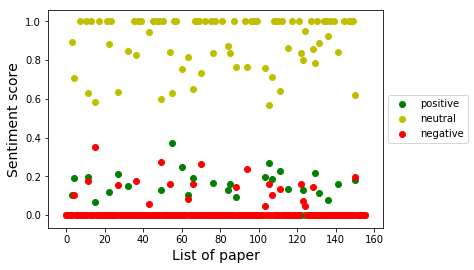

In [89]:
import matplotlib.pyplot as plt

x = np.arange(len(df_sentiment))
df_sentiment['compound']

#plt.close()
#comp = plt.scatter(x,df_sentiment['compound'])
pos = plt.scatter(x,df_sentiment['pos'], color = 'g')
neu = plt.scatter(x,df_sentiment['neu'], color = 'y')
neg = plt.scatter(x,df_sentiment['neg'], color = 'r')

plt.legend((pos, neu, neg),('positive', 'neutral','negative'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("List of paper", fontsize=14)
plt.ylabel("Sentiment score", fontsize=14)

plt.savefig("sentiment.png")
plt.show()
